# Combining R & python in RStudio
*Michael Stadler*  
*May 27, 2020*

## Introduciton
In this exercise, we will work with a Jupyter notebook and use `rpy2` to enable running of R code. The exercise is following a similar structure as the "Combining R & Python in RStudio" exercise.

## Links that may be useful during the exercise

- "R Markdown: The Definitive Guide" (free online book): https://bookdown.org/yihui/rmarkdown/
- Jupyter lab (high level overview of basic functionality): https://towardsdatascience.com/jupyter-lab-evolution-of-the-jupyter-notebook-5297cacde6b
- IPython magic commands: https://ipython.readthedocs.io/en/stable/interactive/magics.html
- `rpy2` documenation: https://rpy2.github.io/doc/latest/html/
- `pandas.DataFrame` documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
- `matplotlib` documentation: https://matplotlib.org/contents.html
- `ggplot2` documentation: https://ggplot2.tidyverse.org/


## Jupyter notebooks and JupyterLab

`Jupyter Notebook` is a language agnostic, web-based interactive environment for creating, executing and visualizing Jupyter notebooks, developed by the `Jupyter Project`. The `Jupyter Project` started in 2014 as a spin-off from `IPython` (Interactive Python). IPython continued to exist as a Python shell and kernel for Jupyter, but the notebook interface and other language-agnostic parts of IPython were moved under the Jupyter name. The name `Jupyter` is a reference to core programming languages supported by Jupyter, which are Julia, Python, and R.

`JupyterLab` is the latest user interface (first stable release in February 2018) for Project Jupyter and together with RStudio one of the two renku "Environments" that we use in our course. `JupyterLab` offers similar building functions as RStudio (notebook, terminal, text editor, file browser, etc.).

For more details see the Wikipedia articles for [IPython](https://en.wikipedia.org/wiki/IPython) and [Jupyter Project](https://en.wikipedia.org/wiki/Project_Jupyter).

## Jupyter language kernels
Different programming languages are supported through *lanuage kernels*. A Jupyter kernel handles various types of requests (e.g. code completion and execution) and generates results to be included in the notebook. A large number of kernels are available for Jupyter (see [link](https://github.com/jupyter/jupyter/wiki/Jupyter-kernels)), however we will be only using the default Python kernel augmented by `rpy2` to work with R. For this to work, R needs to be available on the system.


## Use R within Jupyter notebooks
In terms of the language integration approaches discussed in the introduction, `rpy2` falls in-between the "bridge" and the "true integration" approaches: It provides both a specific interfact to run R from python, and it also enables direct use of R within a notebook. In this exercise we will use both approaches intermixed.

In order to enable direct use of R code in notebook cells, we use `rpy2`'s `Rmagic` (see [link](https://rpy2.github.io/doc/latest/html/interactive.html#module-rpy2.ipython.rmagic) for details). Please note that this is currently described as an "experimental package", and the "bridge" interface (e.g. using `rpy2.robjects`) may be preferred in some cases. The `rmagic` extension is loaded using the code below. Amongst other things, that will start and initialize the R process (see also [rpy2.rinterface.initr()](https://rpy2.github.io/doc/latest/html/rinterface.html)), and will enable the `%R` and `%%R` specifiers that mark a code line or chunk as containing R code.


In [1]:
%load_ext rpy2.ipython

A line or chunk of R code are started using:  
`%R [OPTIONS] [code [code ...]]`

`code` is the R code, and `OPTIONS` are optional.
Commonly used `OPTIONS` are:  

**Variable sharing**  
- `-i INPUT`: Names of Python variable to be assigned to an R variable of the same name. Multiple names can be passed separated only by commas with no whitespace.  
- `-o OUTPUT`: Names of R variable to be pushed to Python after executing cell body. Multiple names can be passed separated only by commas with no whitespace.  
- `-n`: Enforce to not return anything  

**Plotting**  
- `-w WIDTH`: Width of the R plotting device  
- `-h HEIGHT`: Height of the R plotting device  
- `-p POINTSIZE`: Pointsize of the R plotting device  
- `-b BG`: Background color of the R plotting device  

A full documentation of all supported options is available [here](https://rpy2.github.io/doc/latest/html/interactive.html#module-rpy2.ipython.rmagic).

## Share variables between R and Python
Let's make some examples. We use `%R` at the beginning of a line to run a single line of R code:

In [2]:
%R x <- 2

array([2.])

In [3]:
# this is Python
'x' in dir()

False

The value of `x` is shown in the cell's output (default for R-lines with `%R`, but not for R-chunks with `%%R`).

To make the variables available in Python, we need ot use `-o` (here using `%%R` at the beginning of the cell to mark all code in the cell as R code):

In [4]:
%%R -o z
y <- 3
z <- 4

In [5]:
'y' in dir()

False

In [6]:
'z' in dir()

True

In [7]:
z

array([4.])

You can see that variables that live in the R space are not automatically shared with Python and vice versa, expect if we use `-i` or `-o`.

Instead of checking the variables in scope with `dir()`, we can also see all user-defined variables using the `%who` or `%whos` magic (use `%lsmagic` to list available magic commands understood by the IPython kernel, see [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html) for full documentation):

In [8]:
%whos

Variable   Type       Data/Info
-------------------------------
z          ndarray    1: 1 elems, type `float64`, 8 bytes


If you want to input or output variables later, this can be done using `%Rpush` or `%Rpull`:

In [9]:
import numpy as np
a = np.array([4.5,6.3,7.9])
%Rpush a
np.mean(a)

6.233333333333334

In [10]:
%R mean(a)

array([6.23333333])

In [11]:
%Rpull x
np.mean(x)

2.0

In [12]:
%whos

Variable   Type               Data/Info
---------------------------------------
a          ndarray            3: 3 elems, type `float64`, 24 bytes
np         module             <module 'numpy' from '/tu<...>kages/numpy/__init__.py'>
x          FloatSexpVector    <rpy2.rinterface.FloatSex<...>d394fa0> [RTYPES.REALSXP]
z          ndarray            1: 1 elems, type `float64`, 8 bytes


**Remarks:**  
- The sharing of variables using `-i`, `-o`, `%Rpull` and `%Rpush` will create **identically named** variables in both R and Python environments, so it may sometimes be clearer to use `rpy2.robjects` (see below) for accessing an R object from Python, rather than creating two objects with identical names.  
- Importantly, be aware that R names can have dots ('.'), while in Python the dot is used to call object members. To avoid any issues, don’t use R object names containing dots. In some cases, `rpy2` renames R objects or function arguments, by replacing the dot '.' with an underscore '_' (see below).  
- As a reminder, R indexes elements starting from one, while Python starts from zero. `x[1]` would be the first element of `x` in R, but the second element in Python.

## `rpy2` low- and high-level interfaces

`rpy2` provides a low-level and a high-level interface:  

- [rpy2.rinterface](https://rpy2.github.io/doc/latest/html/rinterface.html#module-rpy2.rinterface): Low-level interface to R, when speed and flexibility matter most. Close to R’s C-level API.
- [rpy2.robjects](): High-level interface, when ease-of-use matters most. Should be the right pick for casual and general use. Based on the previous one.

The Python variable `x` above has type `FloatSexpVector`, which is defined by the low-level interface. The Python object can be considered as Python envelopes pointing to data stored and administered in the R space.

In the exercises below, we will however be mostly using the high-level interface that should be more intuitive to use. While low-level objects can be used in most contexts, they are not as easy to work with, for example they are not previewed:

In [13]:
x

<rpy2.rinterface.FloatSexpVector object at 0x7fca9d394fa0> [RTYPES.REALSXP]

In [14]:
len(x)

1

In [15]:
x[0]

2.0

## Accessing R objects using the high-level interface `rpy.robjects`

When using `rpy2`'s high level interface, objects do have a human-friendly preview.

The entry point into the R process is `rpy2.robjects.r`. It is for example able to directly execute R code contained in a string:

In [16]:
import rpy2.robjects as robjects
robjects.r('1 + 2')

3.000000


In [17]:
R_square = robjects.r('function(n) n^2')
R_square(3.0)

9.000000


Objects that would be accessible from the R environment are accessible as attributes of the `r` instance:

In [18]:
robjects.r.ls()

'a','jet.colo...,'jet.colo...,...,'x','y','z'


In [19]:
x2 = robjects.r.x
x2

2.000000


Also R functions can be accessed in this way:

In [20]:
R_mean = robjects.r.mean
R_mean(robjects.r.a)

6.233333


As mentioned before, dots in the R object name are a problem, so this may not always work. A possible workaround is to access such objects using the `__getitem__()` accessor of `r`:

In [21]:
# robjects.r.is.null would not work
is_null = robjects.r['is.null']
is_null(x)

0


The above is an example of how to call an R function from Python. R packages can be imported using `rpy2.robjects.pacakges.importr()`:

In [22]:
from rpy2.robjects.packages import importr

base = importr('base')

In the above example, we made the `base` namespace available to Python using `importr()`. Even though objects in that namespace were already accessible before, the `base` Python object now supports code completion and introspection.

To try this out, let's first create a vector `n` and the rank it using the two equivalent expressions below (using either `%R` or `base`):

In [23]:
n = robjects.r.rnorm(5)
n

-0.896696,-1.972675,0.647811,1.710402,0.368057


In [24]:
robjects.r.rank(n)

2.000000,1.000000,4.000000,5.000000,3.000000


In [25]:
base.rank(n)

2.000000,1.000000,4.000000,5.000000,3.000000


Note the renaming of object, variable or function argument names containing a dot are renamed (replacing '.' by '_'):

In [26]:
# make n available in R
%Rpush n

# add a missing value to n
robjects.r('n[2] <- NA')

# display the modified n
print(robjects.r.n)

[1] -0.8966957         NA  0.6478115  1.7104022  0.3680565



In [27]:
# rank it in R
%R rank(n, na.last = TRUE)

array([1., 5., 3., 4., 2.])

In [28]:
# rank it in Python
base.rank(robjects.r.n, na_last = True)

1.000000,5.000000,3.000000,4.000000,2.000000


## Working with tabular data

Similarly as for `reticulate` in RStudio, `rpy2` provides specific support to share tabular data between R and Python. There are multiple ways to convert and access an R `data.frame` from Python.

By default, `rpy2` will wrap an R `data.frame` using its low-level interface:

In [29]:
# pull R's built-in 'iris' data.frame to Python
%Rpull iris

In [30]:
iris

<rpy2.rinterface.ListSexpVector object at 0x7fca9d3a31e0> [RTYPES.VECSXP]

Things look much nicer if we explicitely use `rpy2`'s high-level interface:

In [31]:
iris2 = robjects.r.iris
iris2

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
...,...,...,...,...


... and they can be made even nicer by activating HTML output in our notebook:

In [32]:
from functools import partial
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

iris2

,,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa
5,6,5.4,3.9,1.7,0.4,setosa
6,7,4.6,3.4,1.4,0.3,setosa
7,8,5.0,3.4,1.5,0.2,setosa
...,...,...,...,...,...,...
148,149,6.2,3.4,5.4,2.3,virginica


Finally, if you prefer to work with `pandas.DataFrame` objects in Python, you can enable automatic convertsion using:

In [33]:
import pandas as pd

from rpy2.robjects import pandas2ri
pandas2ri.activate()

iris3 = robjects.r.iris
iris3

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,virginica
147,6.3,2.5,5.0,1.9,virginica
148,6.5,3.0,5.2,2.0,virginica
149,6.2,3.4,5.4,2.3,virginica


The activation of a special converter for specific objects (R `data.frame` to Python `pandas.DataFrame` in this case) is a paradigm also available for other types of objects. For example, [anndata2ri](https://github.com/theislab/anndata2ri) provides such a mechanisms for single cell data objects, from R `SingleCellExperiment` to Python `anndata`. But let's stay with tabular data for the moment:

In summary, we have at least three possible representations of an R `data.frame`:

In [34]:
# rpy2 (low-level)
iris.__class__

rpy2.rinterface.ListSexpVector

In [35]:
# rpy2 (high-level)
iris2.__class__

rpy2.robjects.vectors.DataFrame

In [36]:
# pandas
iris3.__class__

pandas.core.frame.DataFrame

## Plotting

As mentioned, R plots are included in the cell's output just like graphical output from Python chunks.

For illustration, let's use the `iris` data from above and create the `Sepal.Length` versus `Petal.Length` scatter plot.

As an exercise, we will create the plot using different approaches:  
- R code, in an R code chunk (using `%%R`, also trying out the `-w`, `-h` and `-p` options to control size)
- Python code, using `matplotlib`  
- any other possibility?


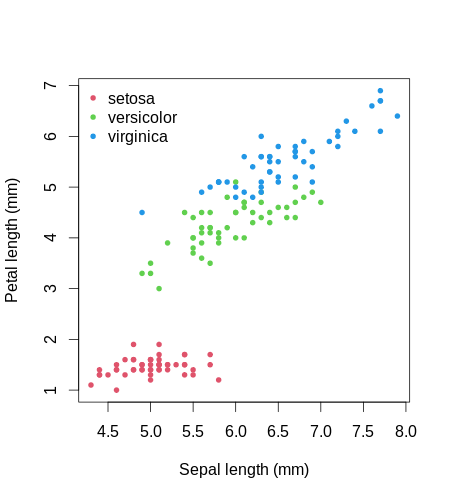

In [37]:
%%R -w 450 -h 500 -p 16

# R code, in an %%R chunk
plot(iris$Sepal.Length, iris$Petal.Length, pch = 20,
     col = as.numeric(iris$Species) + 1,
     xlab = "Sepal length (mm)", ylab = "Petal length (mm)")
legend("topleft", levels(iris$Species), pch = 20, col = 2:4, bty = "n")

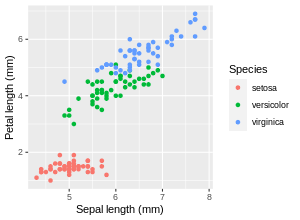

In [38]:
%%R -w 300 -h 220

# again in R in an %%R chunk, but using ggplot2 and different figure size
library(ggplot2)
ggplot(iris, aes(x=Sepal.Length, y=Petal.Length, colour=Species)) +
         geom_point() +
         xlab("Sepal length (mm)") + ylab("Petal length (mm)")

Text(0, 0.5, 'Petal length (mm)')

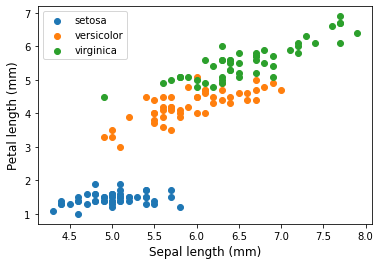

In [39]:
# in Python, using matplotlib and data from a pandas.DataFrame

import matplotlib.pyplot as plt

groups = iris3.groupby('Species')

fig, ax = plt.subplots()

for name, group in groups:
    ax.scatter(x = group["Sepal.Length"], y = group["Petal.Length"], label=name)
ax.legend()

ax.set_xlabel('Sepal length (mm)', fontsize=12)
ax.set_ylabel('Petal length (mm)', fontsize=12)


## Session information

As mentioned already in the RStudio exercise, it is good practise to record what packages and versions have been used for an analysis, e.g. using R's `sessionInfo()`:

In [40]:
%R -n print(sessionInfo())

R version 4.0.0 (2020-04-24)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /tungstenfs/groups/gbioinfo/Appz/easybuild/software/OpenBLAS/0.3.7-GCC-8.3.0/lib/libopenblas_skylakex-r0.3.7.so

locale:
[1] C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0      RColorBrewer_1.1-2

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6     digest_0.6.25    withr_2.2.0      assertthat_0.2.1 dplyr_0.8.5      crayon_1.3.4     grid_4.0.0       R6_2.4.1        
 [9] lifecycle_0.2.0  gtable_0.3.0     magrittr_1.5     scales_1.1.1     pillar_1.4.4     rlang_0.4.6      farver_2.0.3     vctrs_0.3.0     
[17] fortunes_1.5-4   ellipsis_0.3.0   labeling_0.3     glue_1.4.0       purrr_0.3.4      munsell_0.5.0    compiler_4.0.0   pkgconfig_2.0.3 
[25] colorspace_1.4-1 tidyselect_1.1.0 tibble_3.0.1    


... and Python's `sinfo`:

In [41]:
# remove R namespace objects not understood by sinfo
del base
from sinfo import sinfo
sinfo()

-----
matplotlib  3.2.1
numpy       1.18.4
pandas      1.0.3
rpy2        3.3.3
sinfo       0.3.1
-----
IPython             7.14.0
jupyter_client      6.1.3
jupyter_core        4.6.3
jupyterlab          2.1.2
notebook            6.0.3
-----
Python 3.7.7 (default, May  7 2020, 21:25:33) [GCC 7.3.0]
Linux-3.10.0-1062.18.1.el7.x86_64-x86_64-with-centos-7.7.1908-Core
96 logical CPU cores, x86_64
-----
Session information updated at 2020-05-26 10:48
